In [0]:
import pandas as pd
import numpy as np
import tensorflow as tf

# Data Loading

In [10]:
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle


df = pd.read_csv('Day4_Dirty Data_Data_Dirty_Data.csv', sep=';')

source_train, source_test = train_test_split(df[df['set'] == 'source'], test_size=0.1, shuffle=True)
target_train, target_test = train_test_split(df[df['set'] == 'target'], test_size=0.1, shuffle=True) 

print('Source train', source_train.shape, source_train['polarity'].mean())
print('Source test',source_test.shape, source_test['polarity'].mean())
print('Target train', target_train.shape, target_train['polarity'].mean())
print('Target test', target_test.shape, target_test['polarity'].mean())

Source train (9000, 4) 0.5002222222222222
Source test (1000, 4) 0.498
Target train (2250, 4) 0.5066666666666667
Target test (250, 4) 0.44


In [11]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

maxlen = 400 
num_words = 1000 
filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n0123456789'
from keras.preprocessing.text import Tokenizer


tokenizer = Tokenizer(num_words=num_words, filters=filters)
tokenizer.fit_on_texts(source_train['review'].tolist() + target_train['review'].tolist())

x_s_train = pad_sequences(tokenizer.texts_to_sequences(source_train['review'].values) , maxlen)
x_s_test = pad_sequences(tokenizer.texts_to_sequences(source_test['review'].values) , maxlen)
x_t_train = pad_sequences(tokenizer.texts_to_sequences(target_train['review'].values) , maxlen)
x_t_test = pad_sequences(tokenizer.texts_to_sequences(target_test['review'].values) , maxlen)

from sklearn.preprocessing import LabelBinarizer
label_enc = LabelBinarizer().fit(list(set(source_train['polarity'].values))) 
y_s_train = label_enc.transform(source_train['polarity'].values)
y_s_test = label_enc.transform(source_test['polarity'].values)
y_t_train = label_enc.transform(target_train['polarity'].values)
y_t_test = label_enc.transform(target_test['polarity'].values)



# You will see later why movies are encoded
from sklearn.preprocessing import LabelEncoder, OneHotEncoder

movie_enc = LabelEncoder().fit(source_train['movie'].values)
movie_s_train = movie_enc.transform(source_train['movie'].values)
movie_s_test = movie_enc.transform(source_test['movie'].values)
movie_t_train = movie_enc.transform(target_train['movie'].values)
movie_t_test = movie_enc.transform(target_test['movie'].values)

movie_oenc = OneHotEncoder().fit(movie_s_train.reshape(-1, 1))
movie_s_train = movie_oenc.transform(movie_s_train.reshape(-1, 1)).toarray()
movie_s_test = movie_oenc.transform(movie_s_test.reshape(-1, 1)).toarray()
movie_t_train = movie_oenc.transform(movie_t_train.reshape(-1, 1)).toarray()
movie_t_test = movie_oenc.transform(movie_t_test.reshape(-1, 1)).toarray()


Using TensorFlow backend.
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_encoders.py:415: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a LabelEncoder before this OneHotEncoder to convert the categories to integers, then you can now use the OneHotEncoder directly.
  warnings.warn(msg, FutureWarning)


#Models

We define some submodels



In [0]:
from keras.models import Model
from keras.layers import Dense, Embedding, Input, GlobalAveragePooling1D, LeakyReLU


def build_encoder(num_words, maxlen, dim):
  # To encode a text in a dense vector
  x = Input((maxlen, ))
  f = Embedding(output_dim=dim, input_dim=num_words, input_length=maxlen)(x)
  f = GlobalAveragePooling1D()(f)
  return Model(x, f)

def build_labeler(dim):
  # To decode a dense vector in a label
  f = Input((dim, ))
  y = Dense(dim)(f)
  y = LeakyReLU(0.3)(y)
  y = Dense(dim)(y)
  y = LeakyReLU(0.3)(y)
  y = Dense(1, activation='sigmoid')(y)
  return Model(f, y)
 
def build_discriminator(dim, n_domain):
  # To decode a dense vector in a domain
  f = Input((dim, ))
  d = Dense(dim)(f)
  d = LeakyReLU(0.3)(d)
  d = Dense(dim)(d)
  d = LeakyReLU(0.3)(d)
  d = Dense(n_domain, activation='softmax')(d)
  return Model(f, d)


def trainer(loss, var, lr):
  optimizer = tf.train.AdamOptimizer(lr)
  return optimizer.minimize(loss, var_list=var)

We define a generic class for our adversarial model

In [0]:
from keras.losses import binary_crossentropy, categorical_crossentropy
from keras.metrics import binary_accuracy, categorical_accuracy
from tqdm import tqdm_notebook as tqdm
import matplotlib.pyplot as plt 
from sklearn.manifold import TSNE


class AdversarialModel():
  def __init__(self, dim):
    self.dim = dim
    self.history = {'source accuracy': [], 
                    'target accuracy': [], 
                    'discriminator accuracy': []}
  
  def get_training_data(self, x_s, y_s, x_t, d_s=None, d_t=None):
    self.x_s_train, self.y_s_train, self.x_t_train = x_s, y_s, x_t
    
    # In the classical domain adaptation setting: d_s=0 and d_t=1 (binary
    # domain classification). In our class, we have the possibility to define
    # more complex domain (that's why we use softmax rather than sigmoid)
    
    if d_s is None:
      self.d_s_train, self.d_t_train = np.zeros([x_s.shape[0], 2]), np.zeros([x_t.shape[0], 2])
      self.d_s_train[:, 0] = 1.
      self.d_t_train[:, 1] = 1.
    else:
      self.d_s_train = d_s
      self.d_t_train = d_t
      
  def get_testing_data(self, x_s, y_s, x_t, y_t, d_s=None, d_t=None):
    self.x_s_test, self.y_s_test, self.x_t_test, self.y_t_test = x_s, y_s, x_t, y_t
    
    if d_s is None:
      self.d_s_test, self.d_t_test = np.zeros([x_s.shape[0], 2]), np.zeros([x_t.shape[0], 2])
      self.d_s_test[:, 0] = 1.
      self.d_t_test[:, 1] = 1.
    else:
      self.d_s_test = d_s
      self.d_t_test = d_t

  def compute_graph(self):
    
    # We define the 3 networks (encoder, labeler and discriminator)
    self.encoder = build_encoder(self.x_s_train.max()+1, self.x_s_train.shape[1], self.dim)
    self.labeler = build_labeler(self.dim)
    self.discriminator = build_discriminator(self.dim, self.d_s_train.shape[1])
    
    
    # We define the computational graph
    
    ## Inputs
    self.word_sequences_s = tf.placeholder(shape=[None, self.x_s_train.shape[1]], dtype=tf.int32)
    self.word_sequences_t = tf.placeholder(shape=[None, self.x_s_train.shape[1]], dtype=tf.int32)
    
    ## Outputs
    self.label_s = tf.placeholder(shape=[None, 1], dtype=tf.float32)
    self.label_t = tf.placeholder(shape=[None, 1], dtype=tf.float32)
    
    self.domain_s = tf.placeholder(shape=[None, self.d_s_train.shape[1]], dtype=tf.float32)
    self.domain_t = tf.placeholder(shape=[None, self.d_s_train.shape[1]], dtype=tf.float32)
    
    ## Representations
    self.f_s = self.encoder(self.word_sequences_s)
    self.f_t = self.encoder(self.word_sequences_t)
    
    ## Estimated labels
    self.y_s = self.labeler(self.f_s)
    self.y_t = self.labeler(self.f_t)
    
    ## Estimated domains
    self.d_s = self.discriminator(self.f_s)
    self.d_t = self.discriminator(self.f_t)
    
  def get_batch_train(self, batch_size):
    idx = np.random.randint(0, self.x_s_train.shape[0], batch_size)
    x_s_train_batch, y_s_train_batch, d_s_train_batch = self.x_s_train[idx], self.y_s_train[idx], self.d_s_train[idx]
    
    idx = np.random.randint(0, self.x_t_train.shape[0], batch_size)
    x_t_train_batch, d_t_train_batch = self.x_t_train[idx], self.d_t_train[idx]
    return {self.word_sequences_s: x_s_train_batch, 
            self.word_sequences_t: x_t_train_batch, 
            self.label_s: y_s_train_batch, 
            self.domain_s: d_s_train_batch, 
            self.domain_t: d_t_train_batch}
    
  def compile(self, lbd_adversarial=0.):

    # Losses 
    self.loss_labeler = tf.reduce_mean(binary_crossentropy(self.label_s, self.y_s), axis=0)
    self.loss_discriminator = 0.5*tf.reduce_mean(categorical_crossentropy(self.domain_s, self.d_s), axis=0)
    self.loss_discriminator += 0.5*tf.reduce_mean(categorical_crossentropy(self.domain_t, self.d_t), axis=0)
    self.loss_adversarial = self.loss_labeler - lbd_adversarial*self.loss_discriminator
    
    # Metrics
    self.accuracy_s = tf.reduce_mean(binary_accuracy(self.label_s, self.y_s), axis=0)
    self.accuracy_t = tf.reduce_mean(binary_accuracy(self.label_t, self.y_t), axis=0)
    
    self.accuracy_discriminator =  0.5*tf.reduce_mean(categorical_accuracy(self.domain_s, self.d_s), axis=0)
    self.accuracy_discriminator += 0.5*tf.reduce_mean(categorical_accuracy(self.domain_t, self.d_t), axis=0)
    
    # Optimizers 
    self.pretrain_labeler = trainer(self.loss_labeler, self.encoder.trainable_weights + self.labeler.trainable_weights, 0.01)
    self.train_discriminator = trainer(self.loss_discriminator, self.discriminator.trainable_weights, 0.01)
    self.train_adversarial = trainer(self.loss_adversarial, self.encoder.trainable_weights + self.labeler.trainable_weights, 0.005)
    
  def compute_metrics(self):
    self.history['source accuracy'].append(self.sess.run(self.accuracy_s, {self.word_sequences_s: self.x_s_test, self.label_s: self.y_s_test}))
    self.history['target accuracy'].append(self.sess.run(self.accuracy_t, {self.word_sequences_t: self.x_t_test, self.label_t: self.y_t_test}))
    self.history['discriminator accuracy'].append(self.sess.run(self.accuracy_discriminator, {self.word_sequences_s: self.x_s_test, 
                                                                                              self.word_sequences_t: self.x_t_test,
                                                                                              self.domain_s: self.d_s_test, 
                                                                                              self.domain_t: self.d_t_test}))
    
  def training(self, epochs_pretrain=3, epochs=10, batch_size=32, n_critic=10, n_metrics=100):
    iterations = int(self.x_s_train.shape[0]*1.*epochs_pretrain/batch_size)
    
    init = tf.global_variables_initializer()
    self.sess = tf.Session()
    self.sess.run(init)
    
    print('Representation pretraining')
    for _ in tqdm(range(iterations)):
      self.sess.run(self.pretrain_labeler, self.get_batch_train(batch_size))
      
    print('Discriminator pretraining')
    for _ in tqdm(range(iterations)):
      self.sess.run(self.train_discriminator, self.get_batch_train(batch_size))
      
    self.compute_metrics()
   
    print('Adversarial training')
    iterations = int(self.x_s_train.shape[0]*1.*epochs/batch_size)
    for _ in tqdm(range(iterations)):
      self.sess.run(self.train_adversarial, self.get_batch_train(batch_size))
      for __ in range(n_critic):
        self.sess.run(self.train_discriminator, self.get_batch_train(batch_size))

      if _%n_metrics == 0:
        self.compute_metrics()
        
  def close(self):
    self.sess.close()
    
  def plot_learning(self):
    plt.figure(figsize=(7, 7))
    
    for metric in self.history.keys():
      plt.plot(np.asarray(self.history[metric]), label=metric);
    plt.legend();
    plt.show()
    
  def visualize_representations(self):
    features_source = self.sess.run(self.f_s, {self.word_sequences_s: x_s_test})
    features_target = self.sess.run(self.f_t, {self.word_sequences_t: x_t_test})
    features = np.concatenate([features_source, features_target], axis=0)
    features_tsne = TSNE(n_components=2).fit_transform(features)
    features_tsne_source = features_tsne[:features_source.shape[0]]
    features_tsne_target = features_tsne[features_source.shape[0]:]
    
    features_tsne_source_pos = features_tsne_source[y_s_test.reshape(-1) == 1, :]
    features_tsne_source_neg = features_tsne_source[y_s_test.reshape(-1) == 0, :]
    features_tsne_target_pos = features_tsne_target[y_t_test.reshape(-1) == 1, :]
    features_tsne_target_neg = features_tsne_target[y_t_test.reshape(-1) == 0, :]

    alpha_source = 0.2
    alpha_target = 0.5

    plt.figure(figsize=(7,7))
    plt.scatter(features_tsne_source_pos[:, 0], features_tsne_source_pos[:, 1], alpha=alpha_source, label='source positive'); 
    plt.scatter(features_tsne_source_neg[:, 0], features_tsne_source_neg[:, 1], alpha=alpha_source, label='source negative');
    plt.scatter(features_tsne_target_pos[:, 0], features_tsne_target_pos[:, 1], alpha=alpha_target, label='target positive'); 
    plt.scatter(features_tsne_target_neg[:, 0], features_tsne_target_neg[:, 1], alpha=alpha_target, label='target negative');
    plt.legend()
    plt.show()

#Training

We first train a model without adversary

W0709 16:43:59.750589 140034382997376 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0709 16:43:59.767547 140034382997376 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0709 16:43:59.772748 140034382997376 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0709 16:43:59.905838 140034382997376 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:3376: The name tf.log is deprecated. Please use tf.math.log instead.

W0709 16:43:59.912733 140034382997376 deprecation.py:323] From /usr/

Representation pretraining



Discriminator pretraining



Adversarial training


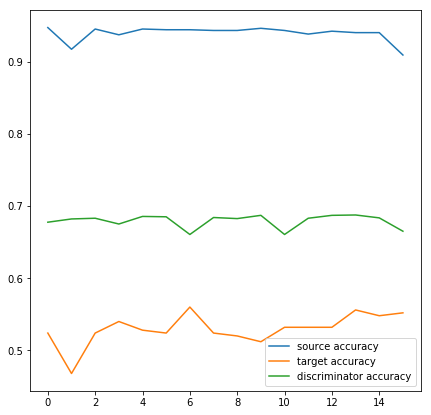

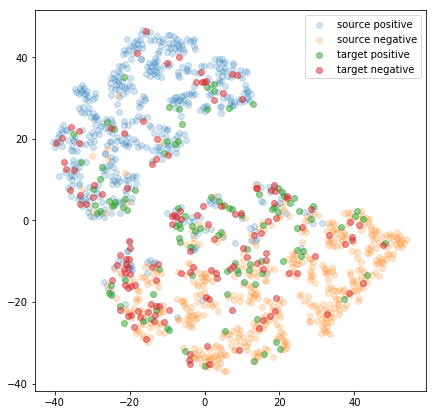

In [15]:
model = AdversarialModel(20)
model.get_training_data(x_s_train, y_s_train, x_t_train)
model.get_testing_data(x_s_test, y_s_test, x_t_test, y_t_test)
model.compute_graph()
model.compile(lbd_adversarial=0.) # No adversary mode
model.training(epochs=5, epochs_pretrain=3, batch_size=32)
model.plot_learning()
model.visualize_representations()

From the TSNE visualization, we observe that source  data is well-separated (blue vs orange) while target data is not separated (red vs green): this is the reason why we have ~50% accuracy on the target domain... Although target representations are disseminated in source representations, a discriminator has the capacity the disentangle achieving ~70% accuracy to discriminate source vs target domains.

Now we plug an adversary to enforce representations to not be distinguishable.

Representation pretraining



Discriminator pretraining



Adversarial training


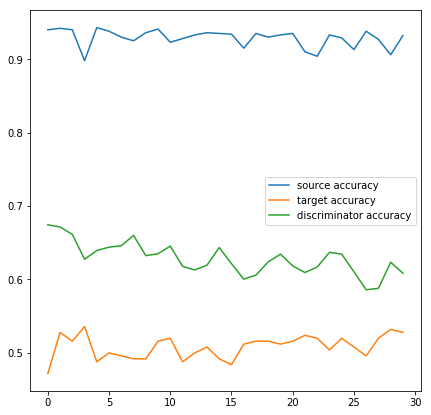

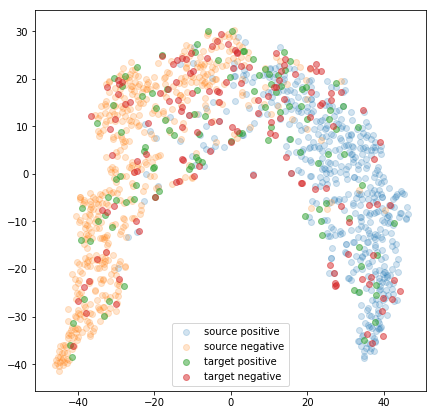

In [16]:
model = AdversarialModel(20)
model.get_training_data(x_s_train, y_s_train, x_t_train)
model.get_testing_data(x_s_test, y_s_test, x_t_test, y_t_test)
model.compute_graph()
model.compile(lbd_adversarial=1.) # adversary mode with lbd = 1.
model.training(epochs=10, epochs_pretrain=3, batch_size=32)
model.plot_learning()
model.visualize_representations()

Hum....... The discriminator is fooled (~55%) but the accuracy on the target domain does not increase... We can observe that representations from the source and the target domains are hard to disentangle (the discriminator did the job!) but red / green points are not well-separated! We missed something... You can play with the hyper-parameters but I failed to be upper than ~60% accuracy on the target domain.

I suspect that it is much easier to forget features with semantic meaning (e.g. 'good', 'bad', 'great', ...) than movie specific features. In our problem, features are roughly organized as follows $X = (X_m, X_s)$ where $X_m$ are movie specific features (e.g. 'Christian', 'shade', 'grey') and $X_s$ are semantic features (e.g. 'good', 'bad', 'great', ...). Correlation between $X_m$ and $X_s$ is inverted between the source and target domains. The model has to choose between $X_m$ or $X_s$ for estimating the polarity but can not use both! The best trade-off accuracy / domain invariance is then obtained with $X_m$... 

If such explication is true, we should observe 0% accuracy on the target domain - which is not the case - then somehting more complex is happening. But, we can still try to validate our insight by enforcing features to be movie invariant (then the discriminator is trained to identify the movie).


Representation pretraining



Discriminator pretraining



Adversarial training


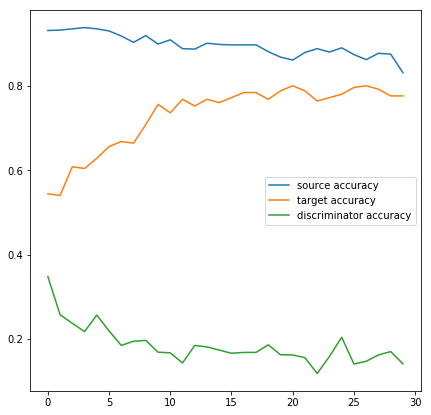

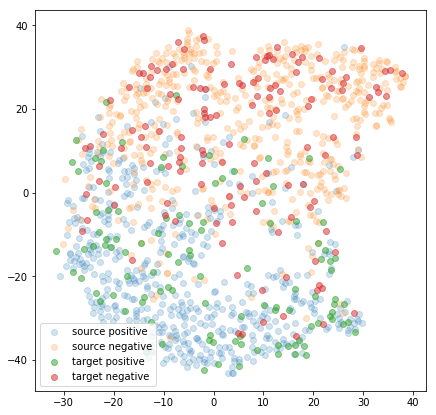

In [17]:
model = AdversarialModel(20)
model.get_training_data(x_s_train, y_s_train, x_t_train, movie_s_train, movie_t_train)
model.get_testing_data(x_s_test, y_s_test, x_t_test, y_t_test, movie_s_test, movie_t_test)
model.compute_graph()
model.compile(lbd_adversarial=10.)
model.training(epochs=10, epochs_pretrain=3, batch_size=32)
model.plot_learning()
model.visualize_representations()

![Texte alternatif…](http://www4.pictures.zimbio.com/mp/zgWFptmpEKSx.jpg)

Wow, what a great ending! we were right!!!!

Few words to conclude on that experiment:
- real world data can be very dirty and the role of the datascientist is to mitigate it!
- we emulate dirtyness with data collected from the amazon reviews dataset. The dirtyness is a bit asymptotic (but is it unrealistic?) since a movie is associated with a given polarity (and the polarity is reversed in the target domain). 
- the classical pipeline (from sklearn.blabla import great_model) will fail... Even advanced technics based on adversarial domain adaptation has failed!
- I spent one day to figure out what was going on... Some insights and dataviz has helped me to find a working solution! 

Some advices: 
- always check your data, 
- do unit test, 
- visualize what is learned,
- do not trust a model  (a model is built on assumptions: does your problem check them?)

And sorry for not having found a working solution during our coding session!

![Texte alternatif…](https://ih1.redbubble.net/image.440458808.7961/sticker,375x360-bg,ffffff.u1.png)